# Week 12: Colab Experiment

# I. Introduction
In this exercise, we learn an autoencoder to reconstruct the MNIST images and extract the representations.

In [1]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import random


In [2]:
# Run this once to load the train and test data straight into a dataloader class
# that will provide the batches
batch_size_train = 64
batch_size_test = 1000
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 38.3MB/s]


Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 1.21MB/s]


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 3.24MB/s]

Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw



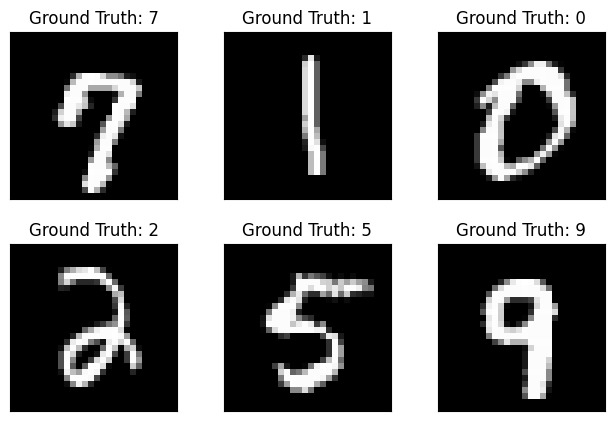

In [3]:
# Let's draw some of the training data
examples = enumerate(test_loader)
batch_idx, (example_data, example_targets) = next(examples)

fig = plt.figure()
for i in range(6):
  plt.subplot(2,3,i+1)
  plt.tight_layout()
  plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
  plt.title("Ground Truth: {}".format(example_targets[i]))
  plt.xticks([])
  plt.yticks([])
plt.show()

# II. Methods

In [4]:
# TODO : Finish the Model
class LAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # TODO
            # The encoder at least 3 hidden layers, each with 128, 64, and 2 hidden units respectively
            nn.Flatten(),           # Flatten the input image
            nn.Linear(28 * 28, 128),    # First hidden layer with 128 units
            nn.ReLU(),             # Activation function
            nn.Linear(128, 64),        # Second hidden layer with 64 units
            nn.ReLU(),
            nn.Linear(64, 2),         # Latent space with 2 units
        )

        self.decoder = nn.Sequential(
            # TODO
            # The decoder also has at least 3 layers with the same number of hidden units in reversed order
            nn.Linear(2, 64),         # First hidden layer in decoder
            nn.ReLU(),
            nn.Linear(64, 128),        # Second hidden layer
            nn.ReLU(),
            nn.Linear(128, 28 * 28),     # Output layer
            nn.Sigmoid(),            # Activation function to keep pixel values in range [0, 1]
            nn.Unflatten(1, (1, 28, 28))   # Reshape to image size
            )

    def forward(self, x):
      # TODO
      latent = self.encoder(x)  # Pass input through encoder
      x = self.decoder(latent)  # Pass latent space through decoder
      return x,latent

# Training steps

In [5]:
num_epochs = 10
learning_rate = 2e-3


model = LAutoencoder()
criterion = nn.MSELoss()
optimizer = torch.optim.AdamW(
    model.parameters(), lr=learning_rate)

# TODO : Finish the training steps
for epoch in range(num_epochs):
    for data in train_loader:
      #  TODO
      images, _ = data  # Get images from data
      images = images.to(torch.float32)  # Ensure correct dtype

      # Forward pass
      reconstructed, latent = model(images)
      loss = criterion(reconstructed, images)

      # Backward pass
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.data.item()}')


epoch [1/10], loss:0.6735265851020813
epoch [2/10], loss:0.6816472411155701
epoch [3/10], loss:0.6783441305160522
epoch [4/10], loss:0.6438592076301575
epoch [5/10], loss:0.6487224102020264
epoch [6/10], loss:0.6350323557853699
epoch [7/10], loss:0.6186027526855469
epoch [8/10], loss:0.5550636649131775
epoch [9/10], loss:0.6126139760017395
epoch [10/10], loss:0.6262013912200928


## III. Results

We train the autoencoder model and apply it to the test set. There is no validation set here, we simply take the model at the end of the training procedure. The scatter plot of the embeddings are shown below, with each digit colored differently.

In [6]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns


def scatter_plot(data_loader):

  d = {0: 'red', 1: "green", 2: "blue", 3: "maroon", 4: "yellow",
      5: "pink", 6: "brown", 7: "black", 8: "teal", 9: "aqua"}

  colors = []
  latent_variables = []
  labels = []

  for data in test_loader:
    img, label = data
    img = img.view(img.size(0), -1)
    model.cpu()
    _,latent = model(img)
    latent_variables.append(latent)
    labels.append(label)


  latent_variables = torch.cat(latent_variables, dim=0)
  labels = torch.cat(labels, dim=0)


  df = pd.DataFrame(data = latent_variables.detach().numpy(), columns = ['Latent feature 1', 'Latent feature 2'])
  df['label'] = labels.numpy()

  fig = plt.figure(dpi=200)
  sns.scatterplot(data=df, x="Latent feature 1", y="Latent feature 2", hue="label", palette="deep")
  plt.show()

The test set:


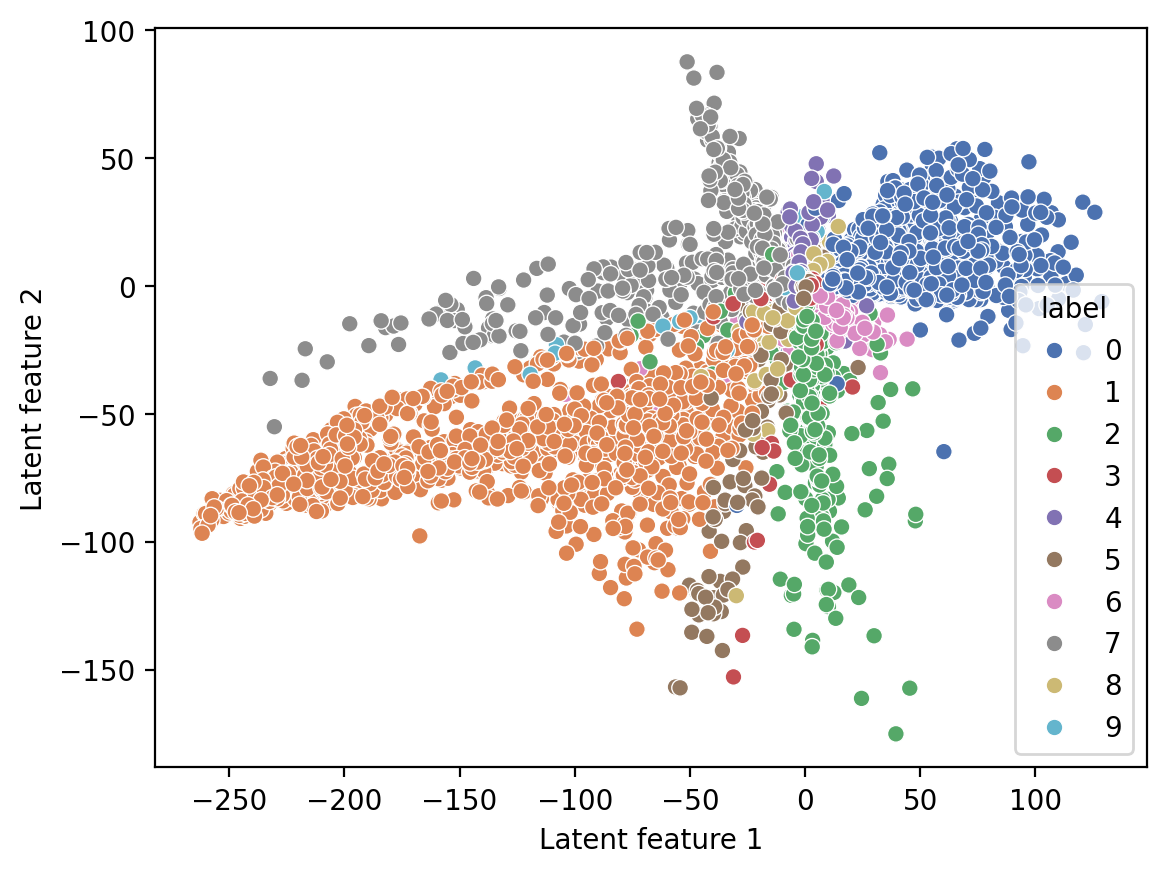

In [7]:
print("The test set:")
scatter_plot(test_loader)

# IV. Conclusion and Discussion



**Discussion**

　　從實驗結果的圖可以看出不同數字（0-9）在二維 latent 空間中呈現出一定的分布特徵，但某些類別之間的區分度不高，部分數字之間的分布可能重疊或相近，例如「3」和「5」，表示 autoencoder 的 latent 空間可能在得到數字特徵方面還有進步的空間。


　　此外，在 10 個訓練週期內， loss 從 0.67 開始下降，最終收斂在大約 0.62。但是在訓練中損失的下降幅度相對有限，且在某些週期中（例如第 9 到 10 次）存在上升趨勢，可能表明模型尚未完全收斂，或者學習率等參數需進一步調整。


　　根據損失數據，模型在重建輸入圖像時的準確性有限，尤其是在更複雜的數字形狀或邊緣模糊的情況下，重建的圖像可能會與原始輸入存在較大的誤差。
　　此模型的 encoder 和 decoder 各包含三層隱藏層，latent 空間的大小設定為 2。雖然簡化模型結構方便可視化，但也可能限制模型對數據的表徵能力，尤其是在處理更高維的 MNIST 圖像數據時。


**Conclusion**

　　從實驗結果可看出實驗的 autoencoder 模型在 MNIST 數據集上的基本重建能力有限，但是 latent 空間能夠部分分離不同類別的數字，展示一定的特徵提取能力。但是，模型在準確性與穩定性方面仍需改進。


　　目前推測可以透過以下方式進行改進：
1. 增加 encoder 和 decoder 的隱藏層數或單層神經元數，並嘗試使用更大的 latent 空間維度。
2. 調整學習率或引入動態學習率調整機制，避免損失出現波動。
3. 引入 dropout 或 L2 regularization，避免模型過擬合。


　　最後，此實驗顯示 autoencoder 能夠在降維和特徵提取方面發揮作用，尤其是在數據可視化和聚類分析中。同時，模型可以作為其他生成模型的基礎結構進行擴展（例如變分自編碼器 VAE）。